# Exercise 1 - Calculate $\pi$

Using the **DSMC method**, calculate the value of **$\pi$**.


**Approach:**
In order to do this, create a 2-dimensional domain (defined by the coordinates $x_{min}, x_{max}, y_{min}, y_{max}$) and launch a number P of particles at random locations within. Check which particles lie inside a circle with radius $$ \frac{x_{max}-x_{min}}{2}, $$ where $x_{min}, x_{max}$ are the x-limits of your 2D domain. 

Get your value for $\pi$ by using the following formula:
$\pi = \frac{4 \cdot n_{inside}}{P},$ where $n_{inside}$ is the number of particles inside the circle and $P$ is the total number of particles.

**a)** Play around with the number of particles and plot your calculated value as a function of this number. 

**b)** Also plot the difference between the value you obtained for $\pi$ and the real one (as a function of P). 

**c)** Make a plot for your domain, highlighting the particles that are inside the circle.

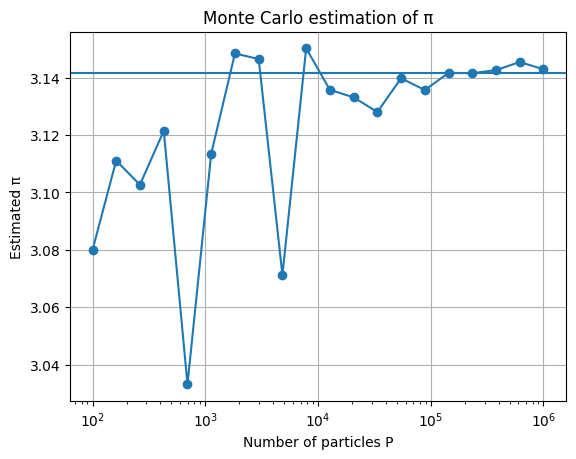

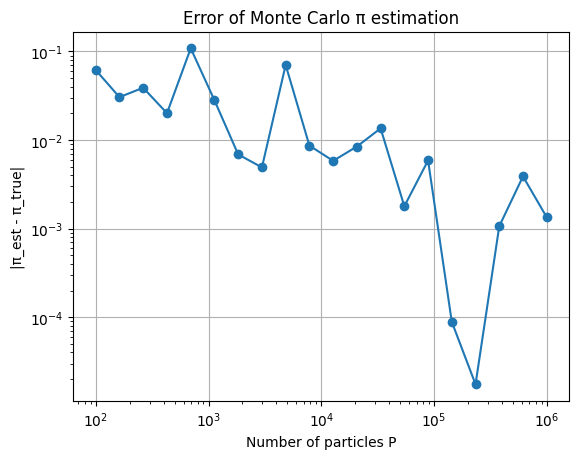

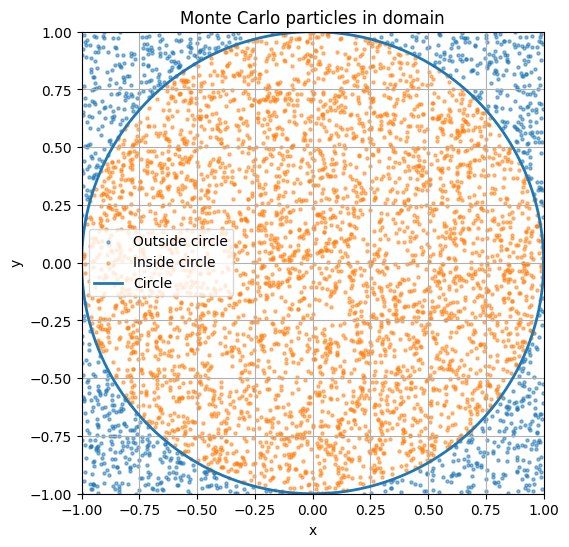

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


xmin, xmax = -1.0, 1.0
ymin, ymax = -1.0, 1.0
R = (xmax - xmin) / 2.0          # radius of circle
pi_true = np.pi

# Different particle numbers
P_values = np.logspace(2, 6, 20, dtype=int)

pi_estimates = []
pi_errors = []

# Monte Carlo loop
for P in P_values:
    x = np.random.uniform(xmin, xmax, P)
    y = np.random.uniform(ymin, ymax, P)

    r2 = x**2 + y**2
    inside = r2 <= R**2
    n_inside = np.sum(inside)

    pi_est = 4.0 * n_inside / P
    pi_estimates.append(pi_est)
    pi_errors.append(abs(pi_est - pi_true))


# a) π estimate vs P
plt.figure()
plt.plot(P_values, pi_estimates, marker='o')
plt.axhline(pi_true)
plt.xscale("log")
plt.xlabel("Number of particles P")
plt.ylabel("Estimated π")
plt.title("Monte Carlo estimation of π")
plt.grid(True)
plt.show()

# b) Error vs P
plt.figure()
plt.plot(P_values, pi_errors, marker='o')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of particles P")
plt.ylabel("|π_est - π_true|")
plt.title("Error of Monte Carlo π estimation")
plt.grid(True)
plt.show()


# c) Domain plot with particles
P_vis = 5000
x = np.random.uniform(xmin, xmax, P_vis)
y = np.random.uniform(ymin, ymax, P_vis)
inside = x**2 + y**2 <= R**2

theta = np.linspace(0, 2*np.pi, 400)

plt.figure(figsize=(6,6))
plt.scatter(x[~inside], y[~inside], s=5, alpha=0.5, label="Outside circle")
plt.scatter(x[inside], y[inside], s=5, alpha=0.5, label="Inside circle")
plt.plot(R*np.cos(theta), R*np.sin(theta), linewidth=2, label="Circle")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.gca().set_aspect("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Monte Carlo particles in domain")
plt.legend()
plt.grid(True)
plt.show()


# Exercise 2 - Metropolis-Hastings

Using the Metropolis-Hastings algorithm, find the standard deviation $\sigma$ and mean value $\mu$ of a random Gaussian distribution. The data to be used for this exercise can be found in the file "input_data.txt".

**Approach (i.e. how the Metropolis-Hastings algorithm looks like):** Start with an initial guess for your standard deviation and mean (you can use the built-in numpy functions for this). 

Generate new values by adding some random noise to the previous/initial guess. Get the noise from a probability distribution. Use for example a Gaussian distribution which you can get via the function

In [ ]:
from scipy.stats import norm
norm(parameter, sigma_m).rvs()

from the scipy.stats package, where $sigma_m$ is the average step size. One can assume a value of 0.1 for this, or play around with this parameter and see what happens. Make sure your sigma isn't lower than zero, otherwise you will end up with NaNs or other weird values.

Compute the likelihood of your new values. Remember the likelihood formula from the lecture and apply it to your points. Compare the likelihood of the new and old values and accept the most relevant value. 

**Note:** Should the likelihood of your new value be lower than the older one, you can use the _acceptance-rejection criterion_ to determine which one to keep (see lecture slides and use a random _r_ value between 0 and 1).

Repeat until you converge on a value (ideally the same one as the values computed with the built-in functions).

For the following plots make sure to include the true values as well, i.e. overplot $\sigma$ and $\mu$ where relevant.

**a)** Plot $\mu$ as a function of the number of iterations.

**b)** Plot $\sigma$ as a function of the number of iterations.

**c)** Make a plot of the dataset you were given and overplot your best fit.

**d)** [OPTIONAL] Please repeat **a)**, **b)**, and **c)**, but this time use the emcee package discussed in Exercise Sheet 8. Do you get the same result as with your own implementation of an MCMC sampler? What is the difference between the sampler implemented by the emcee package and the Metropolis-Hastings algorithm?

/tmp/ipykernel_2967/3822526562.py:111: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(log_alpha)



Acceptance rate: 0.94
Estimated mean (mu): 6.4547
Estimated standard deviation (sigma): 15.6730


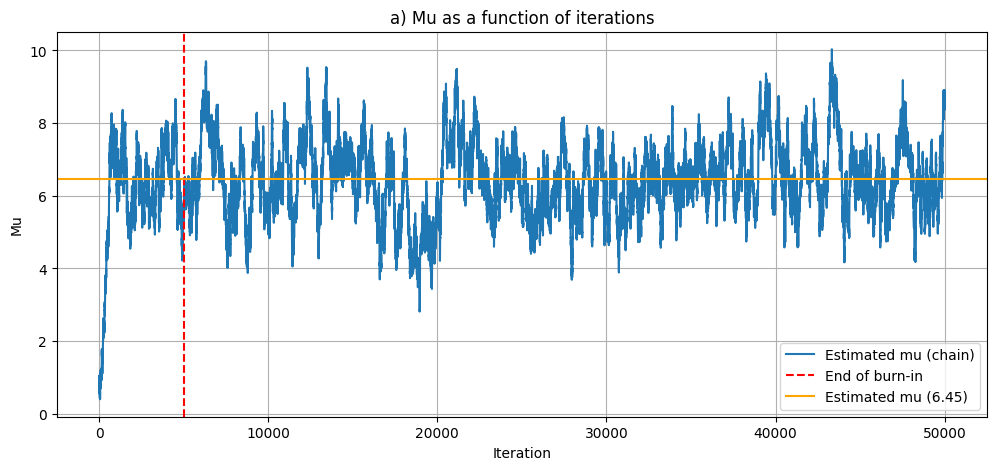

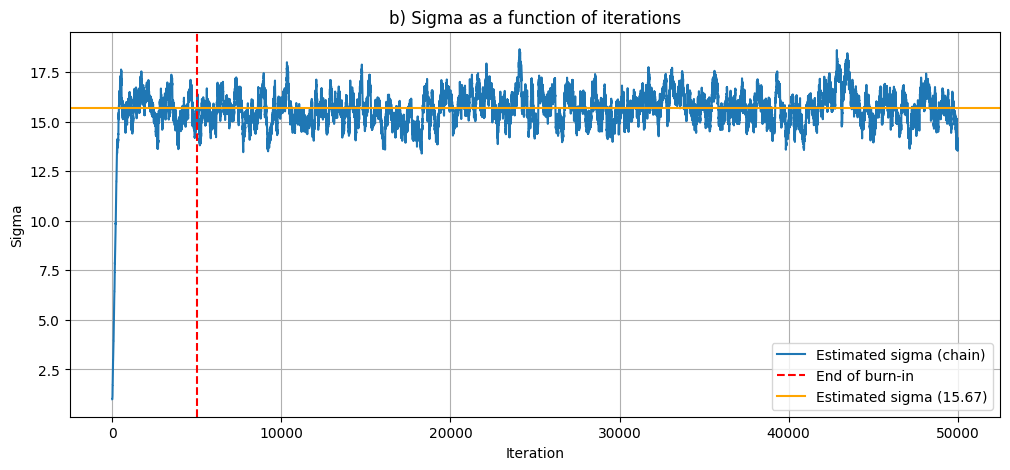

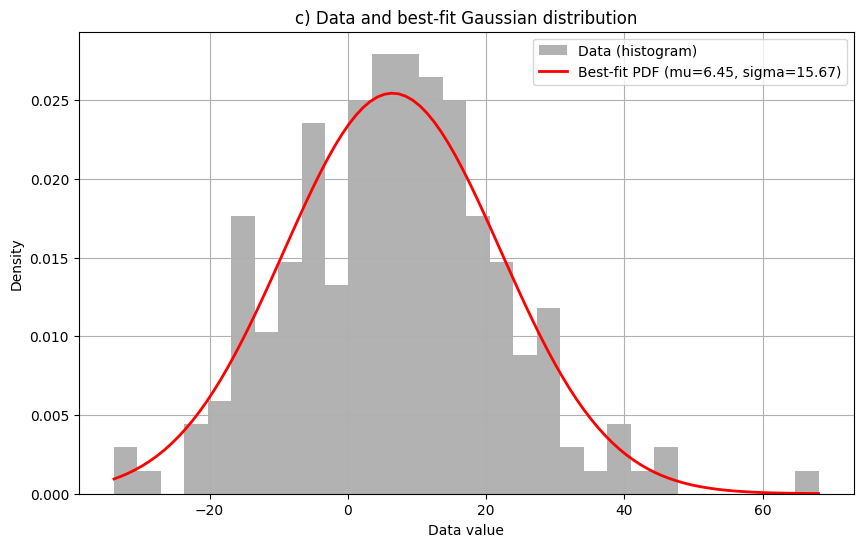

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


data = np.loadtxt('input_data.txt')

N = len(data)

# True values (only used for plotting, if known)
true_mu_plot = 5.0
true_sigma_plot = 2.0


# Log-likelihood function for a normal distribution
def log_likelihood(params, data):
    """
    Computes the log-likelihood of the data given
    the parameters mu and sigma of a Gaussian distribution.

    Parameters:
        params : array-like
            [mu, sigma]
        data : array-like
            Observed data points

    Returns:
        log_l : float
            Log-likelihood value
    """
    mu, sigma = params
    
    # Sigma must be positive
    if sigma <= 0:
        return -np.inf
    
    # Sum of log-probabilities for all data points
    log_l = np.sum(norm.logpdf(data, loc=mu, scale=sigma))
    return log_l



# Proposal function for the Metropolis-Hastings algorithm
def proposal_function(current_params, step_size):
    """
    Generates a new proposal point by adding Gaussian noise
    to the current parameters.

    Parameters:
        current_params : array-like
            Current values of [mu, sigma]
        step_size : float
            Standard deviation of the proposal distribution

    Returns:
        new_params : np.ndarray
            Proposed new parameters [mu, sigma]
    """
    # Random Gaussian perturbations
    mu_noise = norm.rvs(loc=0, scale=step_size)
    sigma_noise = norm.rvs(loc=0, scale=step_size)

    # Propose new parameters
    new_mu = current_params[0] + mu_noise
    new_sigma = current_params[1] + sigma_noise
    
    # Ensure sigma stays positive
    if new_sigma <= 0:
        new_sigma = 1e-4

    return np.array([new_mu, new_sigma])


# Initialization of the Markov Chain
initial_mu = 1.0
initial_sigma = 1.0

current_params = np.array([initial_mu, initial_sigma])

# Number of MCMC iterations
n_iterations = 50000

# Step size of the proposal distribution
step_size = 0.1

# Array to store the Markov chain
chain = np.zeros((n_iterations, 2))

# Counter for accepted proposals
acceptance_rate = 0



# Metropolis-Hastings MCMC loop
for i in range(n_iterations):
    # Propose new parameters
    proposed_params = proposal_function(current_params, step_size)

    # Compute log-likelihoods
    current_log_l = log_likelihood(current_params, data)
    proposed_log_l = log_likelihood(proposed_params, data)
    
    # Log of the acceptance ratio
    log_alpha = proposed_log_l - current_log_l
    alpha = np.exp(log_alpha)
    
    # Draw a uniform random number for acceptance test
    r = np.random.uniform(0, 1)
    
    # Accept or reject the proposal
    if r < alpha:
        current_params = proposed_params
        acceptance_rate += 1

    # Store current parameters in the chain
    chain[i] = current_params


# Compute final acceptance rate
acceptance_rate /= n_iterations
print(f"\nAcceptance rate: {acceptance_rate:.2f}")


# Burn-in removal and parameter estimation
burn_in = int(n_iterations * 0.1)
chain_post_burnin = chain[burn_in:]

# Posterior mean estimates
estimated_mu = np.mean(chain_post_burnin[:, 0])
estimated_sigma = np.mean(chain_post_burnin[:, 1])

print(f"Estimated mean (mu): {estimated_mu:.4f}")
print(f"Estimated standard deviation (sigma): {estimated_sigma:.4f}")

if true_values_known:
    print(f"True mean: {true_mu:.4f}")
    print(f"True standard deviation: {true_sigma:.4f}")


# a) Trace plot for mu
plt.figure(figsize=(12, 5))
plt.plot(chain[:, 0], label='Estimated mu (chain)')
plt.axvline(burn_in, color='red', linestyle='--', label='End of burn-in')
plt.axhline(estimated_mu, color='orange', linestyle='-', 
            label=f'Estimated mu ({estimated_mu:.2f})')

if true_values_known:
    plt.axhline(true_mu_plot, color='green', linestyle=':', 
                label=f'True mu ({true_mu_plot:.2f})')

plt.title('a) Mu as a function of iterations')
plt.xlabel('Iteration')
plt.ylabel('Mu')
plt.legend()
plt.grid(True)
plt.show()


# b) Trace plot for sigma
plt.figure(figsize=(12, 5))
plt.plot(chain[:, 1], label='Estimated sigma (chain)')
plt.axvline(burn_in, color='red', linestyle='--', label='End of burn-in')
plt.axhline(estimated_sigma, color='orange', linestyle='-', 
            label=f'Estimated sigma ({estimated_sigma:.2f})')

if true_values_known:
    plt.axhline(true_sigma_plot, color='green', linestyle=':', 
                label=f'True sigma ({true_sigma_plot:.2f})')

plt.title('b) Sigma as a function of iterations')
plt.xlabel('Iteration')
plt.ylabel('Sigma')
plt.legend()
plt.grid(True)
plt.show()



# c) Histogram of data with best-fit Gaussian PDF
plt.figure(figsize=(10, 6))

# Histogram of the observed data
plt.hist(data, bins=30, density=True, alpha=0.6,
         color='grey', label='Data (histogram)')

# Range for plotting the fitted PDF
x_range = np.linspace(data.min(), data.max(), 100)

# Gaussian PDF using estimated parameters
best_fit_pdf = norm.pdf(x_range, loc=estimated_mu, scale=estimated_sigma)
plt.plot(x_range, best_fit_pdf, 'r-', linewidth=2,
         label=f'Best-fit PDF (mu={estimated_mu:.2f}, sigma={estimated_sigma:.2f})')

plt.title('c) Data and best-fit Gaussian distribution')
plt.xlabel('Data value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()
